In [38]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [39]:
# Load dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Create SQLite database
conn = sqlite3.connect("churn_project.db")

# Save data to SQL table called 'customers'
df.to_sql("customers", conn, if_exists="replace", index=False)

# Preview first 5 rows
pd.read_sql("SELECT * FROM customers LIMIT 5;", conn)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


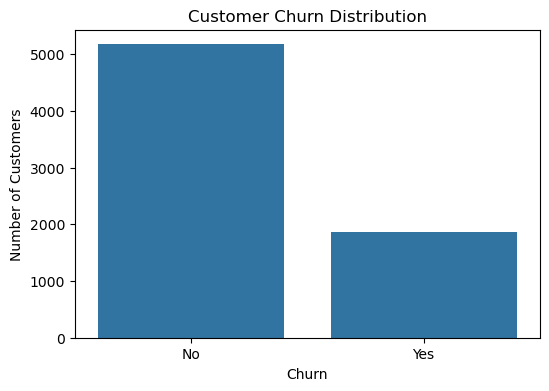

In [40]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title("Customer Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Number of Customers")
plt.show()

In [41]:
query = """
SELECT
    Contract,
    COUNT(*) AS total_customers,
    SUM(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END) AS churned_customers,
    ROUND(100.0 * SUM(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END) / COUNT(*), 2) AS churn_rate
FROM customers
GROUP BY Contract
ORDER BY churn_rate DESC;
"""

pd.read_sql(query, conn)

,Contract,total_customers,churned_customers,churn_rate
0,Month-to-month,3875,1655,42.71
1,One year,1473,166,11.27
2,Two year,1695,48,2.83


In [42]:
## checking null values 
query = """
SELECT
    SUM(CASE WHEN gender IS NULL THEN 1 ELSE 0 END) AS missing_gender,
    SUM(CASE WHEN SeniorCitizen IS NULL THEN 1 ELSE 0 END) AS missing_senior,
    SUM(CASE WHEN TotalCharges = '' OR TotalCharges IS NULL THEN 1 ELSE 0 END) AS missing_totalcharges
FROM customers;
"""
pd.read_sql(query, conn)

,missing_gender,missing_senior,missing_totalcharges
0,0,0,0


In [43]:
# Add a new column with numeric TotalCharges
query = """
ALTER TABLE customers
ADD COLUMN TotalCharges_float REAL;
"""
try:
    conn.execute(query)
except:
    pass  

# Fill new column with numeric values
query = """
UPDATE customers
SET TotalCharges_float = CASE
    WHEN TotalCharges = '' THEN NULL
    ELSE CAST(TotalCharges AS REAL)
END;
"""
conn.execute(query)
conn.commit()

In [44]:
# Step 1: Add the column
alter_query = """
ALTER TABLE customers
ADD COLUMN tenure_group TEXT;
"""
try:
    conn.execute(alter_query)
except:
    pass  

# Step 2: Update the column
update_query = """
UPDATE customers
SET tenure_group = CASE
    WHEN tenure BETWEEN 0 AND 12 THEN '0-12 months'
    WHEN tenure BETWEEN 13 AND 24 THEN '13-24 months'
    WHEN tenure BETWEEN 25 AND 48 THEN '25-48 months'
    WHEN tenure BETWEEN 49 AND 72 THEN '49-72 months'
    ELSE 'Unknown'
END;
"""
conn.execute(update_query)
conn.commit()

In [45]:

df = pd.read_sql("SELECT * FROM customers;", conn)

# Drop unnecessary columns
df.drop(['customerID', 'TotalCharges'], axis=1, inplace=True)

# Fill missing numeric values
df['TotalCharges_float'].fillna(df['TotalCharges_float'].median(), inplace=True)

# Convert target column to binary
df['Churn'] = df['Churn'].apply(lambda x: 1 if x=='Yes' else 0)

# Convert categorical columns to dummy variables
df = pd.get_dummies(df, drop_first=True)



C:\Users\77075\AppData\Local\Temp\ipykernel_11968\89812282.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges_float'].fillna(df['TotalCharges_float'].median(), inplace=True)


In [46]:
df.head()

,SeniorCitizen,tenure,MonthlyCharges,Churn,TotalCharges_float,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_13-24 months,tenure_group_25-48 months,tenure_group_49-72 months
0,0,1,29.85,0,29.85,False,True,False,False,True,...,False,False,False,True,False,True,False,False,False,False
1,0,34,56.95,0,1889.50,True,False,False,True,False,...,False,True,False,False,False,False,True,False,True,False
2,0,2,53.85,1,108.15,True,False,False,True,False,...,False,False,False,True,False,False,True,False,False,False
3,0,45,42.30,0,1840.75,True,False,False,False,True,...,False,True,False,False,False,False,False,False,True,False
4,0,2,70.70,1,151.65,False,False,False,True,False,...,False,False,False,True,False,True,False,False,False,False


In [47]:
# Features (X) and target (y)
top_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges_float',
                'Contract_One year','Contract_Two year','PaperlessBilling_Yes']

X = df[top_features]
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Training Accuracy: 0.9934
Test Accuracy: 0.7637

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.82      0.87      0.84      1036
           1       0.56      0.47      0.51       373

    accuracy                           0.76      1409
   macro avg       0.69      0.67      0.68      1409
weighted avg       0.75      0.76      0.76      1409



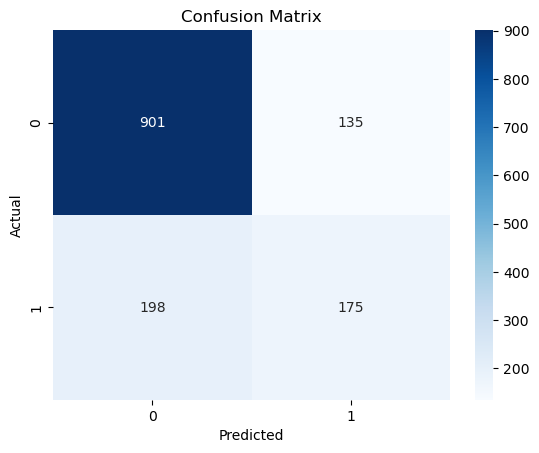

In [48]:


# Initialize model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
model.fit(X_train, y_train)

# Predict on training data
y_train_pred = model.predict(X_train)

# Predict on test data
y_test_pred = model.predict(X_test)

# Training accuracy
train_acc = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", round(train_acc, 4))

# Test accuracy
test_acc = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", round(test_acc, 4))

# Classification report (on test data)
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_test_pred))

# Confusion matrix (on test data)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [49]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=42)

# Train model
log_model.fit(X_train, y_train)

# Predict on train and test
y_train_pred_log = log_model.predict(X_train)
y_test_pred_log = log_model.predict(X_test)

# Training accuracy
train_acc_log = accuracy_score(y_train, y_train_pred_log)
print("Logistic Regression - Training Accuracy:", round(train_acc_log, 4))

# Test accuracy
test_acc_log = accuracy_score(y_test, y_test_pred_log)
print("Logistic Regression - Test Accuracy:", round(test_acc_log, 4))

# Classification report
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_test_pred_log))

Logistic Regression - Training Accuracy: 0.7868
Logistic Regression - Test Accuracy: 0.8048

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036
           1       0.67      0.53      0.59       373

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409



In [50]:
print("Model Comparison:")
print(f"Random Forest - Train Acc: {round(train_acc, 4)}, Test Acc: {round(test_acc, 4)}")
print(f"Logistic Regression - Train Acc: {round(train_acc_log, 4)}, Test Acc: {round(test_acc_log, 4)}")

Model Comparison:
Random Forest - Train Acc: 0.9934, Test Acc: 0.7637
Logistic Regression - Train Acc: 0.7868, Test Acc: 0.8048


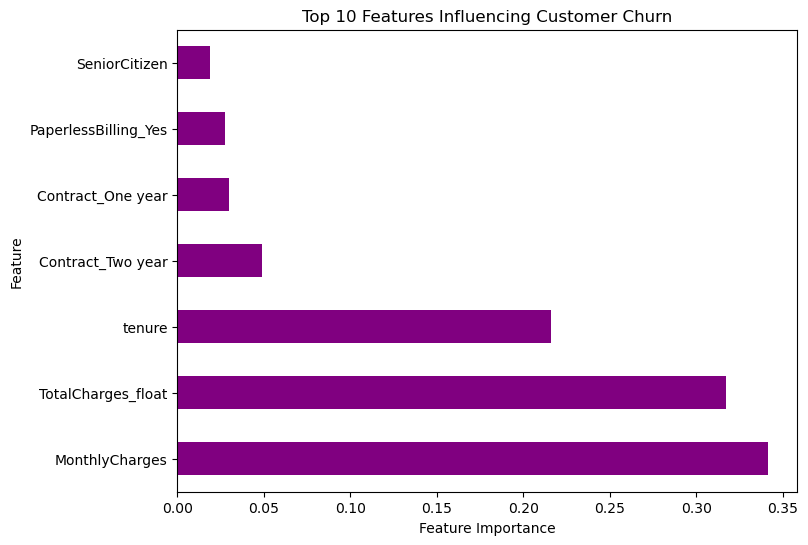

In [51]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(8,6))
feat_importances.nlargest(10).plot(kind='barh', color='purple')
plt.title("Top 10 Features Influencing Customer Churn")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

In [55]:
###Save model to file
import pickle
pickle.dump(log_model, open("new_churn_model.pkl", "wb"))
print(" Model saved as new churn_model.pkl")

 Model saved as new churn_model.pkl


In [53]:
print(X_train.columns)

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges_float',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes'],
      dtype='object')
